# T1
### Exercise 1

We want to get a grip on T1 relaxation curves as commonly observed in **I**nversion **R**ecovery acquisitions

**ToDo** Add sequence diagram

In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.style.use('ggplot')

### Signal Model
We define the relaxation signal model for T1 relaxation from inversion recovery, using initial magnetization and T1 as parameters
$$ S(t) = M_0 \left( 1 - 2 e^{-\frac{t}{T_1}} \right) $$

In [3]:
# define relaxation model
def e_1(t:float, t1_val:float, m_0:float = 1.0):
    # take times in same order of magnitude (s, ms, us)
    # define equilibrium magnetization to be normalized at 1 by default
    return m_0 * (1 - np.exp(-t/t1_val))

def t1_relaxation(t: float, t1_val: float, m_0: float = 1.0):
    return - m_0 * np.exp(-t/t1_val) + e_1(t, t1_val, m_0)

T1 describes the regain of longitudinal magnetization. After an Inversion pulse the net magnetization drops to -1. We can take a look at different relaxation curves dependent on the Tissue T1.

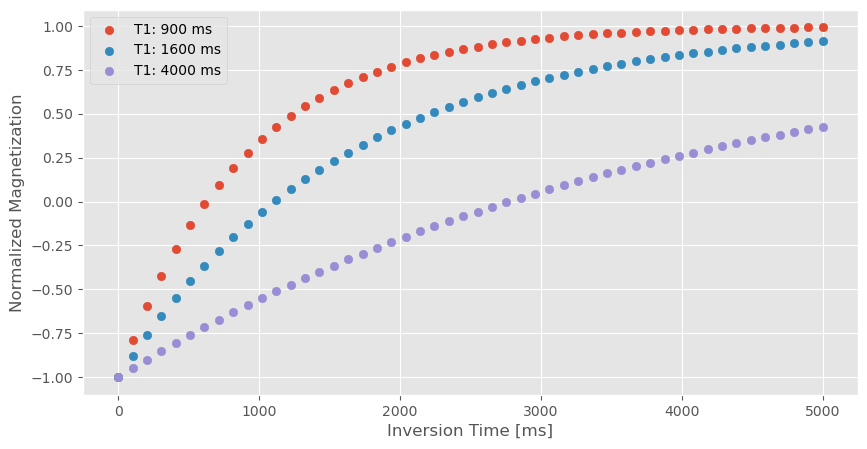

In [4]:
T1 = [900, 1600, 4000]      # [ms]
T_Inv = np.linspace(0, 5000, 50)  # inversion times, [ms]


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()

for t1_idx in range(T1.__len__()):
    ax.scatter(T_Inv, t1_relaxation(T_Inv, T1[t1_idx]), label=f"T1: {T1[t1_idx]} ms")

ax.set_ylabel("Normalized Magnetization")
ax.set_xlabel("Inversion Time [ms]")
ax.legend()
plt.show()

### $T_R$ and $\rho$
We also set some functions describing what happens a bit better for signal creation. First we include the inversion efficiency $\rho$ into the equation

In [5]:
def t1_ir_relaxation(t:float, t1_val:float, rho: float = 1.0, m_initial: float = 1.0):
    # use either both times in seconds or ms
    # inversion flip angle defines starting value,
    # default: 180 degrees
    m_start = m_initial * np.cos(np.radians(rho * 180.0))
    # relaxation curve
    longitudinal_magnetization = m_start * np.exp(-t / t1_val) + e_1(t, t1_val)
    return longitudinal_magnetization


The repetition time defines the initial magnetization available. A short TR leads to insufficient relaxation, i.e. the longitudinal magnetization will not reattain its initial state (1.0). Subesequent acquisitions have less magnetization to start with.
We adapt the description and plot

In [6]:
def calculate_steady_state_magnetization(t1_val:float, tr_val:float, rho:float = 1.0, m_0:float = 1.0):
    # calculate "available" magnetization due to insufficient relaxation, like in an experiment this settles after a few repetitions (starting with 1)
    m_ss_last = t1_ir_relaxation(tr_val, t1_val, rho, m_0)
    m_ss = t1_ir_relaxation(tr_val, t1_val, rho, m_ss_last)
    while np.abs(m_ss - m_ss_last) > 1e-6:
        m_ss_last = m_ss
        m_ss = t1_ir_relaxation(tr_val, t1_val, rho, m_ss_last)
    return m_ss


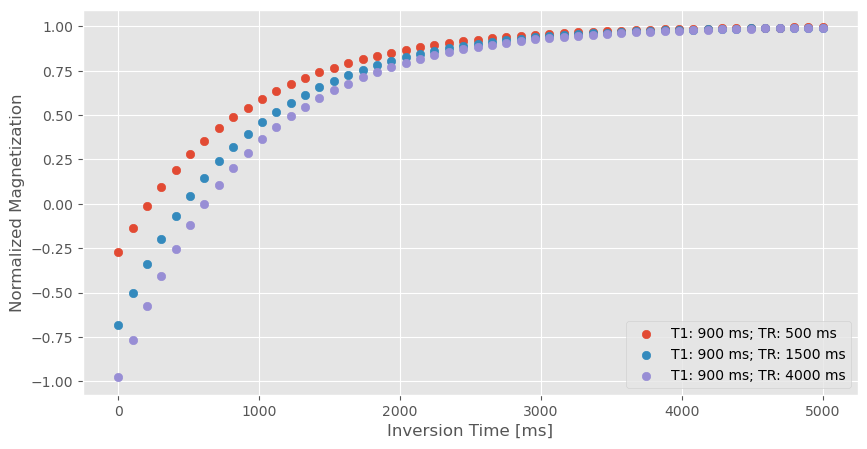

In [7]:
TR = [500, 1500, 4000]      # [ms]
T_Inv = np.linspace(0, 5000, 50)  # inversion times, [ms]
T1 = 900       # [ms] around value for gray matter
# available magnetization due to insufficient relaxation
m_tr = [calculate_steady_state_magnetization(T1, tr) for tr in TR]
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()

for tr_idx in range(TR.__len__()):
    ax.scatter(T_Inv, t1_ir_relaxation(t=T_Inv, t1_val=T1, m_initial=m_tr[tr_idx]), label=f"T1: {T1} ms; TR: {TR[tr_idx]} ms")

ax.set_ylabel("Normalized Magnetization")
ax.set_xlabel("Inversion Time [ms]")
ax.legend()
plt.show()

We see that shorter repetition times TR lead to less available initial magnetization.
Since TR marks the repetition of the experiment the above signal curves would actually look different considering the "restart of the experiment". This might exemplify why the starting point of the relaxation curves change: Dotted lines mark the repetition of the inversion pulses

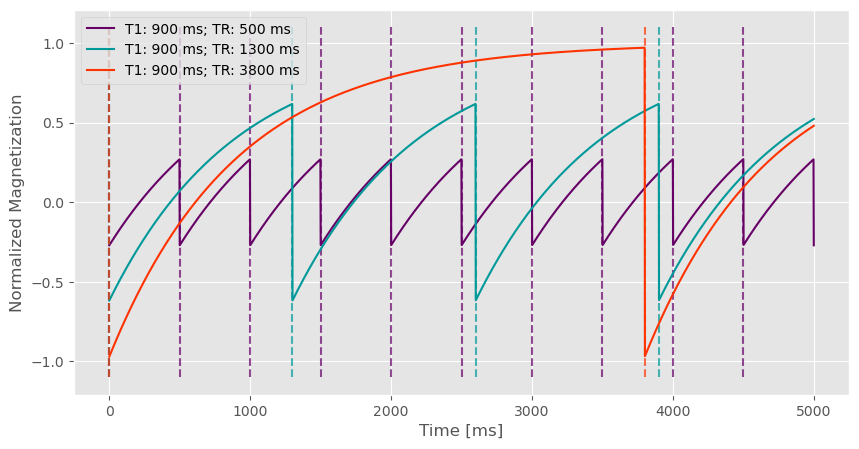

In [8]:
TR = [500, 1300, 3800]      # [ms]
T_Inv = np.linspace(0, 5000, 2500)  # inversion times, [ms]
T1 = 900       # [ms] around value for gray matter
# available magnetization due to insufficient relaxation
m_tr = [calculate_steady_state_magnetization(T1, tr) for tr in TR]

colors = ['#660066', '#009999', '#ff3300']
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()

for tr_idx in range(TR.__len__()):
    ax.plot(T_Inv, t1_ir_relaxation(t=T_Inv % TR[tr_idx], t1_val=T1, m_initial=m_tr[tr_idx]), label=f"T1: {T1} ms; TR: {TR[tr_idx]} ms", color=colors[tr_idx])
    ax.vlines(np.arange(int(np.ceil(T_Inv[-1] / TR[tr_idx]))) * TR[tr_idx], -1.1, 1.1, color=colors[tr_idx], linestyles='dashed', alpha=0.7)

ax.set_ylabel("Normalized Magnetization")
ax.set_xlabel("Time [ms]")
ax.legend()
plt.show()

## Fitting
### Influence of TR
Now we are interested in what happens if we fit our data by the standard T1 model we defined in the beginning, but the acquisition is influenced by our choice of TR.

In [9]:
T1 = 900
TR_s = 800
TR_l = 4000
datapoints = 15
time_array_s = np.linspace(0, TR_s, datapoints)
time_array_l = np.linspace(0, TR_l, datapoints)

# create noisy data
m_trs = calculate_steady_state_magnetization(T1, TR_s)
trs_data = t1_ir_relaxation(time_array_s, T1, m_initial=m_trs) + 0.1 * (np.random.random(size=datapoints) - 0.5)
m_trl = calculate_steady_state_magnetization(T1,TR_l)
trl_data = t1_ir_relaxation(time_array_l, T1, m_initial=m_trl) + 0.1 * (np.random.random(size=datapoints) - 0.5)

# fit - we choose some sane bounds - [T1, M0]
trs_fit = curve_fit(t1_relaxation, time_array_s, trs_data, p0=[1500, 1.0], bounds=([0.0, 0.0], [10000.0, 10.0]))
trl_fit = curve_fit(t1_relaxation, time_array_l, trl_data, p0=[1500, 1.0], bounds=([0.0, 0.0], [10000.0, 10.0]))
# not too interested in the covariance for now
trs_fit = trs_fit[0]
trl_fit = trl_fit[0]

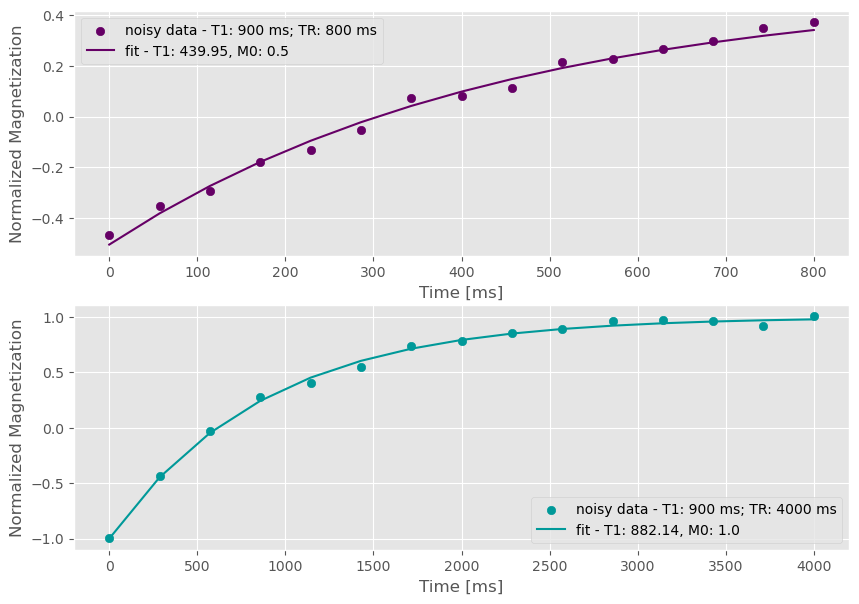

In [10]:
fig = plt.figure(figsize=(10,7))

ax = fig.add_subplot(211)
ax.scatter(time_array_s, trs_data, label=f"noisy data - T1: {T1} ms; TR: {TR_s} ms", color=colors[0])
ax.plot(time_array_s, t1_relaxation(time_array_s, *trs_fit), color=colors[0], label=f"fit - T1: {trs_fit[0]:.2f}, M0: {trs_fit[1]:.1f}")

ax.set_ylabel("Normalized Magnetization")
ax.set_xlabel("Time [ms]")
ax.legend()

ax = fig.add_subplot(212)
ax.scatter(time_array_l, trl_data, label=f"noisy data - T1: {T1} ms; TR: {TR_l} ms", color=colors[1])
ax.plot(time_array_l, t1_relaxation(time_array_l, *trl_fit), color=colors[1], label=f"fit - T1: {trl_fit[0]:.2f}, M0: {trl_fit[1]:.1f}")

ax.set_ylabel("Normalized Magnetization")
ax.set_xlabel("Time [ms]")
ax.legend()


plt.show()

TR introduces bias if not accounted for in the signal modelling! Long TR needed in order to get to good estimates. M0 always remains an unknown in the experiment, i.e. hard to crosscheck!

### Influence of inversion efficiency $\rho$

In [11]:
# create some data with long TR and different inversion efficiencies
TR = 4000       # (from above we assume sufficient relaxation)
T1 = 900
datapoints = 20
time_array = np.linspace(0, TR, datapoints)

rho_1 = 1.0
rho_1_true = t1_ir_relaxation(time_array, T1, rho_1)
rho_1_data = rho_1_true + 0.1 * (np.random.random(size=datapoints) - 0.5)

rho_2 = 0.75
rho_2_true = t1_ir_relaxation(time_array, T1, rho_2)
rho_2_data = rho_2_true + 0.1 * (np.random.random(size=datapoints) - 0.5)
# fit - we choose some sane bounds - [T1, M0]
r1_fit = curve_fit(t1_relaxation, time_array, rho_1_data, p0=[1500, 1.0], bounds=([0.0, 0.0], [10000.0, 2.0]))
r2_fit = curve_fit(t1_relaxation, time_array, rho_2_data, p0=[1500, 1.0], bounds=([0.0, 0.0], [10000.0, 2.0]))
# not too interested in the covariance for now
r1_fit = r1_fit[0]
r2_fit = r2_fit[0]

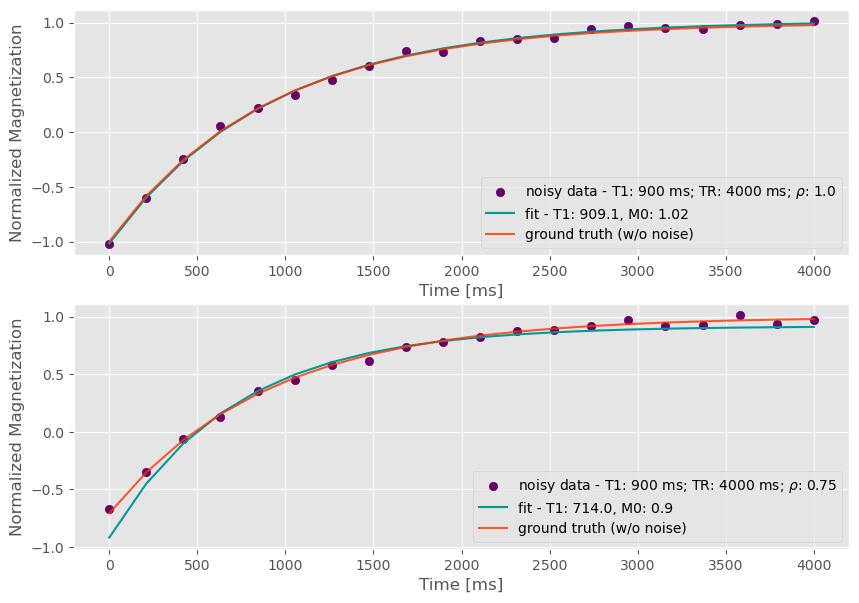

In [12]:
fig = plt.figure(figsize=(10,7))

ax = fig.add_subplot(211)
ax.scatter(time_array, rho_1_data, label=f"noisy data - T1: {T1} ms; TR: {TR} ms; $\\rho$: {rho_1:.1f}", color=colors[0])
ax.plot(time_array, t1_relaxation(time_array, *r1_fit), color=colors[1], label=f"fit - T1: {r1_fit[0]:.1f}, M0: {r1_fit[1]:.2f}")
ax.plot(time_array, rho_1_true, color=colors[2], alpha=0.8, label=f"ground truth (w/o noise)")

ax.set_ylabel("Normalized Magnetization")
ax.set_xlabel("Time [ms]")
ax.legend()

ax = fig.add_subplot(212)
ax.scatter(time_array, rho_2_data, label=f"noisy data - T1: {T1} ms; TR: {TR} ms; $\\rho$: {rho_2:.2f}", color=colors[0])
ax.plot(time_array, t1_relaxation(time_array, *r2_fit), color=colors[1], label=f"fit - T1: {r2_fit[0]:.1f}, M0: {r2_fit[1]:.1f}")
ax.plot(time_array, rho_2_true, color=colors[2], alpha=0.8, label=f"ground truth (w/o noise)")

ax.set_ylabel("Normalized Magnetization")
ax.set_xlabel("Time [ms]")
ax.legend()


plt.show()

We can try to adapt the signal model (to the actual definition we used to produce the ineffective signal) and fit again. Hence, we are additionally looking for an estimate of $\rho$
(Comparing to the latter plot)

In [13]:
# fit - we choose some sane bounds [t1, rho, m0] - rho symmetric around 1.0 from cosine
r2_fit = curve_fit(t1_ir_relaxation, time_array, rho_2_data, p0=[1500, 1.0, 1.0], bounds=([0.0, 0.0, 0.0], [10000.0, 1.0, 2.0]))
# not too interested in the covariance for now
r2_fit = r2_fit[0]

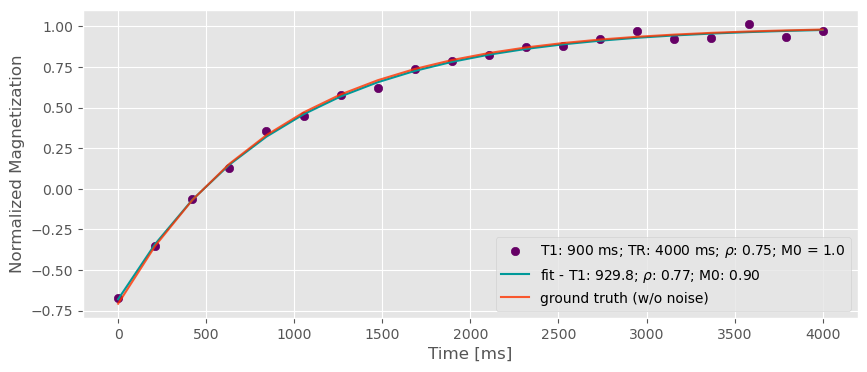

In [14]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot()
ax.scatter(time_array, rho_2_data, label=f"T1: {T1} ms; TR: {TR} ms; $\\rho$: {rho_2:.2f}; M0 = 1.0", color=colors[0])
ax.plot(time_array, t1_ir_relaxation(time_array, *r2_fit), color=colors[1], label=f"fit - T1: {r2_fit[0]:.1f}; $\\rho$: {r2_fit[1]:.2f}; M0: {r2_fit[2]:.2f}")
ax.plot(time_array, rho_2_true, color=colors[2], alpha=0.8, label=f"ground truth (w/o noise)")

ax.set_ylabel("Normalized Magnetization")
ax.set_xlabel("Time [ms]")
ax.legend()


plt.show()